In [17]:
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16

In [2]:
# Define dataset paths
TRAIN_DIR = '../data/processed/train/'
TEST_DIR = '../data/processed/test/'
VAL_DIR = '../data/processed/val/'
IMG_SIZE = (224,224)
BATCH_SIZE = 32

In [23]:
# Image preprocessing using image_dataset_from_directory
train_data = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='binary',
    seed=42
)

Found 125 files belonging to 2 classes.


In [24]:
class_names = train_data.class_names  # Get class names before transformations
print(class_names)

['no_tumor', 'tumor']


In [4]:
test_data = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='binary',
    seed=42
)

Found 27 files belonging to 2 classes.


In [5]:
val_data = tf.keras.utils.image_dataset_from_directory(
    VAL_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode='rgb',
    label_mode='binary',
    seed=42
)

Found 27 files belonging to 2 classes.


In [6]:
# Optimize dataset performance
AUTOTUNE = tf.data.AUTOTUNE
train_data = train_data.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size=AUTOTUNE)

In [7]:
# VGG16 Model with transfer learning
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the convolutional base

In [8]:
# Custom classifier
top_model = models.Sequential([
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

In [10]:
# Combine VGG16 and classifier
model = models.Sequential([base_model, top_model])

In [11]:
top_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 6,423,041
Trainable params: 6,423,041
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 sequential (Sequential)     (None, 1)                 6423041   
                                                                 
Total params: 21,137,729
Trainable params: 6,423,041
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [14]:
# Train the model
history = model.fit(train_data, validation_data=val_data, epochs=10)

Epoch 1/10


2025-04-02 12:18:16.441501: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


4/4 [==============================] - 14s 4s/step - loss: 40.7020 - accuracy: 0.6000 - val_loss: 12.3394 - val_accuracy: 0.5556
Epoch 2/10
4/4 [==============================] - 13s 3s/step - loss: 15.1964 - accuracy: 0.6960 - val_loss: 8.7496 - val_accuracy: 0.8519
Epoch 3/10
4/4 [==============================] - 13s 3s/step - loss: 3.7181 - accuracy: 0.8640 - val_loss: 13.0598 - val_accuracy: 0.7778
Epoch 4/10
4/4 [==============================] - 13s 3s/step - loss: 1.6111 - accuracy: 0.9360 - val_loss: 11.6085 - val_accuracy: 0.8148
Epoch 5/10
4/4 [==============================] - 13s 3s/step - loss: 3.2214 - accuracy: 0.9280 - val_loss: 14.7423 - val_accuracy: 0.8519
Epoch 6/10
4/4 [==============================] - 13s 3s/step - loss: 0.5698 - accuracy: 0.9840 - val_loss: 12.0080 - val_accuracy: 0.8519
Epoch 7/10
4/4 [==============================] - 13s 3s/step - loss: 0.4759 - accuracy: 0.9840 - val_loss: 11.5627 - val_accuracy: 0.8889
Epoch 8/10
4/4 [=====================

In [15]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

1/1 [==============================] - 2s 2s/step - loss: 10.0526 - accuracy: 0.8519
Test Accuracy: 85.19%


In [18]:
# Generate predictions and confusion matrix
y_pred = []
y_true = []
for images, labels in test_data:
    predictions = model.predict(images)
    pred_classes = np.argmax(predictions, axis=1)
    y_pred.extend(pred_classes)
    y_true.extend(labels.numpy())

1/1 [==============================] - 2s 2s/step


In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [21]:
cm

array([[14,  0],
       [13,  0]])

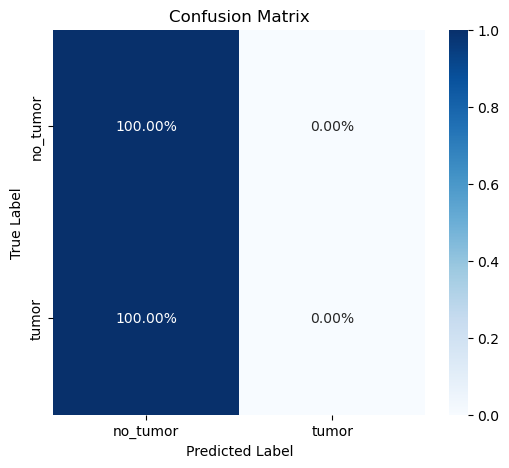

In [26]:
# Compute Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]  # Normalize by row

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm_percentage, annot=True, fmt=".2%", cmap='Blues', xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the model
model.save("VGG_CNN_model.h5")